<h1 style="text-align:center"> Instacart Market Basket Analysis</h1>

This notebook will serve as the analysis of the Instacart data. <br>
This is a competition hosted by Kaggle and the files can be found in the following link: https://www.kaggle.com/c/instacart-market-basket-analysis/data <br>
Instacart is an on-demand grocery delivery platform facilitating doorstep deliveries of groceries and other home essentials in major cities of USA. <br>
In this competition, Instacart is challenging the Kaggle community to use this anonymized data on customer orders over time to predict which previously purchased products will be in a user’s next order. They’re not only looking for the best model, Instacart’s also looking for machine learning engineers to grow their team.

<h3 style="text-align:center"> Load Libraries</h3>

In [ ]:
# Data processing
import pandas as pd
import numpy as np

# Visualization tools
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Train/test split
from sklearn.model_selection import train_test_split

# Time checking
from time import time

Display centered plots

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h3 style="text-align:center">Load Data</h3>

In [3]:
# List of products and relative information (product_id, aisle_id, department_id)
products = pd.read_csv('data/products.csv')

# This file tells to which set (prior, train, test) an order belongs
orders = pd.read_csv('data/orders.csv') 

train_orders = pd.read_csv('data/order_products__train.csv')
prior_orders = pd.read_csv('data/order_products__prior.csv')

# File that assign department_id to department name
dpmt = pd.read_csv('data/departments.csv')

# List of the different aisles (aisle_id -> aisle )
aisles = pd.read_csv('data/aisles.csv')

<u>Saving into pickle file</u>

Saving into pickle file speeds the reading process of the data

In [4]:
# products.to_pickle('data/products.p')
# orders.to_pickle('data/orders.p')
# train_orders.to_pickle('data/order_products_train.p')
# prior_orders.to_pickle('data/order_products_prior.p')
# dpmt.to_pickle('data/departments.p')
# aisles.to_pickle('data/aisle')


# Saving into pickle file
# train_df.to_pickle('train_df.p')
# test_df.to_pickle('test_df.p')

# target.to_pickle('target.p')

<h3 style="text-align:center">Data reduction (memory)</h3>

We will change some column types for less memory usage for the upcoming processing of data. <br>
This FAQ <a href="https://pandas.pydata.org/pandas-docs/stable/gotchas.html">pandas doc</a> gives some insight about DataFrame memory usage.

In [5]:
# print("products file types:\n", products.dtypes)
print("products file types:")
print(products.dtypes, "\n")

print("orders file types:")
print(orders.dtypes, "\n")

print("train_orders types:")
print(train_orders.dtypes, "\n")

print("prior_orders types:")
print(prior_orders.dtypes, "\n")

print("deparments types:")
print(dpmt.dtypes, "\n")

print("aisles types:")
print(aisles.dtypes)

products file types:
product_id        int64
product_name     object
aisle_id          int64
department_id     int64
dtype: object 

orders file types:
order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object 

train_orders types:
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtype: object 

prior_orders types:
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtype: object 

deparments types:
department_id     int64
department       object
dtype: object 

aisles types:
aisle_id     int64
aisle       object
dtype: object


From this, one can infer: 
<ul>
    <li>Most of 'object' types can be converted to 'categorical' types. <br>
    </li>
    <li>64 bytes is not necessary for almost all features, thus reducting this might be a good choice.
    </li>
    <li>
    'float' objects can be casted to int when possible.
    </li>
</ul>


In [6]:
aisles['aisle'] = aisles['aisle'].astype('category')
aisles['aisle_id'] = aisles['aisle_id'].astype(np.int16)

dpmt['department'] = dpmt['department'].astype('category')
dpmt['department_id'] = dpmt['department_id'].astype(np.int16)

products['aisle_id'] = products['aisle_id'].astype(np.int16)
products['department_id'] = products['department_id'].astype(np.int16)
products['product_id'] = products['product_id'].astype(np.int16)
products['product_name'] = products['product_name'].astype('category')

orders['order_id'] = orders['order_id'].astype(np.int32)
orders['user_id'] = orders['user_id'].astype(np.int32)
orders['eval_set'] = orders['eval_set'].astype('category')
orders['order_number'] = orders['order_number'].astype(np.int16)
orders['order_dow'] = orders['order_dow'].astype(np.int16)
orders['order_hour_of_day'] = orders['order_hour_of_day'].astype(np.int16)
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype(np.float16)

train_orders['order_id'] = train_orders['order_id'].astype(np.int32)
train_orders['product_id'] = train_orders['product_id'].astype(np.int32)
train_orders['add_to_cart_order'] = train_orders['add_to_cart_order'].astype(np.int16)
train_orders['reordered'] = train_orders['reordered'].astype(np.int16)

prior_orders['order_id'] = prior_orders['order_id'].astype(np.int32)
prior_orders['product_id'] = prior_orders['product_id'].astype(np.int32)
prior_orders['add_to_cart_order'] = prior_orders['add_to_cart_order'].astype(np.int16)
prior_orders['reordered'] = prior_orders['reordered'].astype(np.int16)

# prior_orders['aisle_id'] = prior_orders['aisle_id'].astype(np.int16)
# prior_orders['department_id'] = prior_orders['department_id'].astype(np.int16)
# prior_orders['aisle'] = prior_orders['aisle'].astype('category')
# prior_orders['department'] = prior_orders['department'].astype('category')


<h3 style="text-align:center">Data Analysis</h3>

In [7]:
# Shape of dataframes
print("products shape:", products.shape)
print("orders shape:", orders.shape)
print("train_orders shape:", train_orders.shape)
print("prior_orders shape:", prior_orders.shape)
print("departments shape:", dpmt.shape)
print("aisles shape", aisles.shape)

products shape: (49688, 4)
orders shape: (3421083, 7)
train_orders shape: (1384617, 4)
prior_orders shape: (32434489, 4)
departments shape: (21, 2)
aisles shape (134, 2)


Next we look for for missing values in each of the dataframes.

In [8]:
print("Missing values in produts:", products.isnull().sum().sum())
print("Missing values in orders:", orders.isnull().sum().sum())
print("Missing values in train_orders:", train_orders.isnull().sum().sum())
print("Missing values in prior_orders:", prior_orders.isnull().sum().sum())

Missing values in produts: 0
Missing values in orders: 206209
Missing values in train_orders: 0
Missing values in prior_orders: 0


Further investigation in orders is needed.

In [9]:
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

There are only missing values in the days_since_prior_order feature of the orders dataframe amongst the several files provided.

Check the values of the different files.

<u>Orders file</u>

In [10]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


<u style="padding-left:1.8em">Understanding eval_set</u>

There are 3 evaluation sets: 'prior', 'train', 'test'. <br>
'prior' refers to customers who had already bought from Instacart before, hence they have a user_id.
'prior' can be found several times from the same user, it just means that multiple previous orders are recorded.<br>
Most importantly, these user classified in the 'prior' evaluation set have <b>either</b> a train or test label.<br>
We need to separate the "true" test and test set from this valuable information.

In [11]:
# an example to understand visually how the problem is structured
orders.loc[orders['user_id'] == 1, :]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [12]:
# Gather user_id from 'train' evaluation set into a list
user_id_train = orders.loc[(orders['eval_set'] == 'train'), 'user_id'].values
# Collect all the orders, 'prior' included, from the train set
train_prior_orders = orders.loc[orders['user_id'].isin(user_id_train), :]

# We repeat this process for the 'test' evaluation set
user_id_test = orders.loc[(orders['eval_set'] == 'test'), 'user_id'].values
test_prior_orders = orders.loc[orders['user_id'].isin(user_id_test), :]

We can verify the result:

In [13]:
train_prior_orders.head(11)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [14]:
test_prior_orders.head(13)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
26,1374495,3,prior,1,1,14,NaN
27,444309,3,prior,2,3,19,9.0
28,3002854,3,prior,3,3,16,21.0
29,2037211,3,prior,4,2,18,20.0
30,2710558,3,prior,5,0,17,12.0
31,1972919,3,prior,6,0,16,7.0
32,1839752,3,prior,7,0,15,7.0
33,3225766,3,prior,8,0,17,7.0
34,3160850,3,prior,9,0,16,7.0
35,676467,3,prior,10,3,16,17.0


<u style="padding-left: 1.8em">Repartition of customers</u>

In [15]:
print(orders.groupby(['eval_set']).size(), "\n")
print(orders.groupby(['eval_set']).size()[1:].sum())

eval_set
prior    3214874
test       75000
train     131209
dtype: int64 

206209


There are 206,209 customers in total out of which the last purchase of 131,209 customers are given as train set and we need to predict for the rest 75,000 customers.

<u style="padding-left: 1.8em">Number of orders</u>

In [16]:
# Extract only 'train' and 'test' order_number
number_order = orders.loc[(orders['eval_set'] == 'train') |  \
                          (orders['eval_set'] == 'test'), 'order_number']

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


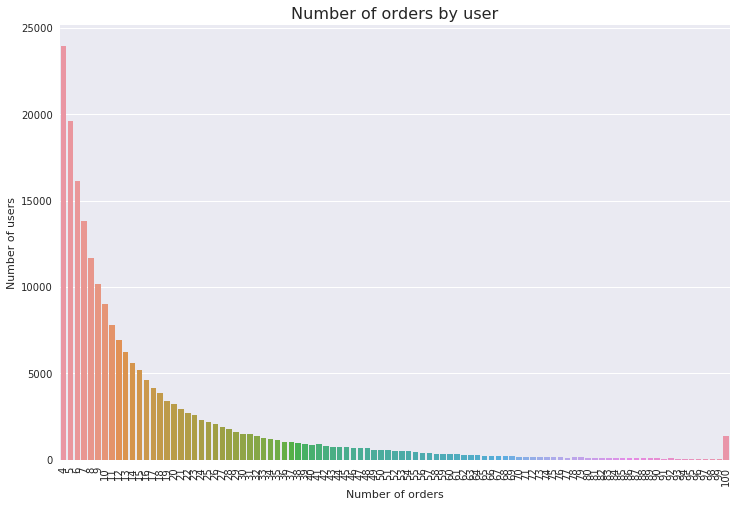

In [17]:
plt.figure(figsize=(12,8))

sns.countplot(x=number_order.values)

plt.title('Number of orders by user', size=16)
plt.xlabel('Number of orders')
plt.ylabel('Number of users')
plt.xticks(rotation='vertical')
plt.show()

We see that for each user is provided between 4 and 100 of their orders.<br>
In order words, each user in the dataset must have have been classified in the 'prior' set due to their past purchases.<br>
One thing that caught my attention is that there are much more users with low number of orders, indeed the whole purpose of this competition makes sense since Instacart's goal is to understand as soon as possible patterns from new customers for them to still buy from the company.

<u>Train orders</u>

In [18]:
train_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


train_orders file contains all the products bought from the order_id. <br>
Each new product bought by the same order_id is assigned to a new row so that we can at each product if the same user has ordered this product in the past. <br>
add_to_cart_order keeps track of the ordering of the products.

In [19]:
train_orders.loc[ train_orders['order_id'] == 1, : ]

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1


<u>prior_orders</u>

In [20]:
prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


As train_orders, prior_orders contain the same type of information, but for the orders on the 'prior' evaluation set only.

<u>Food information</u>

<u>Products</u>

In [21]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [22]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [23]:
dpmt.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


The food information is distribution through different files and merging these data with prior_orders appropriately will help us understand better the information as only id is given in the prior_orders file.

In [24]:
prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [25]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [26]:
# t0 = time()
# prior_orders = prior_orders.merge(products, how='left', on='product_id')
# # prior_orders = prior_orders.merge(aisles, how='left', on='aisle_id')
# # prior_orders = prior_orders.merge(dpmt, how='left', on='department_id')

# t1 = time()
# print("time elapsed:", round((t1-t0), 3), "s")

In [27]:
# t0 = time()
# # prior_orders = prior_orders.merge(products, how='left', on='product_id')
# prior_orders = prior_orders.merge(aisles, how='left', on='aisle_id')
# # prior_orders = prior_orders.merge(dpmt, how='left', on='department_id')

# t1 = time()
# print("time elapsed:", round((t1-t0), 3), "s")

In [28]:
# t0 = time()
# # prior_orders = prior_orders.merge(products, how='left', on='product_id')
# # prior_orders = prior_orders.merge(aisles, how='left', on='aisle_id')
# prior_orders = prior_orders.merge(dpmt, how='left', on='department_id')

# t1 = time()
# print("time elapsed:", round((t1-t0), 3), "s")

In [29]:
prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [30]:
prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [31]:
prior_orders.dtypes

order_id             int32
product_id           int32
add_to_cart_order    int16
reordered            int16
dtype: object

<h3 style="text-align:center">Checkpoint</h3>

In [32]:
products.to_pickle('data/products.p')
orders.to_pickle('data/orders.p')
train_orders.to_pickle('data/order_products_train.p')
prior_orders.to_pickle('data/order_products_prior.p')
dpmt.to_pickle('data/departments.p')
aisles.to_pickle('data/aisle')

In [3]:
# Loading the pickle file, analysis can start here and we don't have to process the previous code each time we come back

products = pd.read_pickle('data/products.p')
orders = pd.read_pickle('data/orders.p')
train_orders = pd.read_pickle('data/order_products_train.p')
prior_orders = pd.read_pickle('data/order_products_prior.p')
dpmt = pd.read_pickle('data/departments.p')
aisles = pd.read_pickle('data/aisle')

<h3 style="text-align:center">Feature Engineering</h3>

First, let's fill the missing values in the days_since_prior_order feature. It corresponds to user's fist purchase.

In [4]:
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0).astype(np.int16)

In [5]:
prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


Now, let's regroup the features.

In [6]:
# Include user_id feature in train_orders

train_orders = train_orders.merge(orders[['user_id', 'order_id']], \
                                  left_on='order_id', right_on='order_id', \
                                  how='inner')

In [7]:
# Merge prior_orders and orders 

# 'inner' use intersetion of keys from both frames
orders_prior_merged = orders.merge(prior_orders, how='inner', on='order_id')

In [8]:
orders_prior_merged.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,0,196,1,0
1,2539329,1,prior,1,2,8,0,14084,2,0
2,2539329,1,prior,1,2,8,0,12427,3,0
3,2539329,1,prior,1,2,8,0,26088,4,0
4,2539329,1,prior,1,2,8,0,26405,5,0


In [9]:
orders_prior_merged.shape

(32434489, 10)

<u>Creating features</u>

We will create features from the orders file

In [10]:
products_df = orders_prior_merged.sort_values(['user_id', 'order_number', 'product_id'], ascending=True)
# get the reorder frequency ('reordered' is just binary value)
products_df['reorder_frequency'] = products_df.groupby(['user_id', 'product_id']).cumcount()+1

# Extract items bought first and second for calculating probability for later
sub1 = products_df[products_df['reorder_frequency'] == 1].groupby('product_id').size().to_frame('bought_first')
sub2 = products_df[products_df['reorder_frequency'] == 2].groupby('product_id').size().to_frame('bought_second')

sub1['count_orders'] = products_df.groupby('product_id').size()
sub1['count_reorders'] = products_df.groupby('product_id')['reordered'].sum()

sub2 = sub2.reset_index().merge(sub1.reset_index())

# Calculate probability of being bought a second time
sub2['reorder_probability'] = sub2['bought_second'] / sub2['bought_first']

# Calculate ratio of reorder product
sub2['ratio_reorder'] = sub2['count_reorders'] / sub2['count_orders']

In [11]:
print(sub1.shape, sub2.shape,)

(49677, 3) (45305, 7)


In [12]:
products_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,reorder_frequency
0,2539329,1,prior,1,2,8,0,196,1,0,1
2,2539329,1,prior,1,2,8,0,12427,3,0,1
1,2539329,1,prior,1,2,8,0,14084,2,0,1
3,2539329,1,prior,1,2,8,0,26088,4,0,1
4,2539329,1,prior,1,2,8,0,26405,5,0,1


In [13]:
# Saving relevant information in a separate dataframe
products_info_df = sub2[['product_id', 'count_orders', \
                         'reorder_probability', 'ratio_reorder']]

In [14]:
products_info_df.head()

,product_id,count_orders,reorder_probability,ratio_reorder
0,1,1852,0.385475,0.613391
1,2,90,0.102564,0.133333
2,3,277,0.486486,0.732852
3,4,329,0.351648,0.446809
4,5,15,0.666667,0.600000


In [15]:
products_info_df.shape

(45305, 4)

We will create features from the orders file 

In [16]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,0
1,2398795,1,prior,2,3,7,15
2,473747,1,prior,3,3,12,21
3,2254736,1,prior,4,4,7,29
4,431534,1,prior,5,4,15,28


In [17]:
# Extract total number of orders
users = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['order_number'].max().to_frame('number_orders')

# Total number of days without purchasing
users['days_no_purchase'] = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['days_since_prior_order'].sum()

# average interval between each purchase by user
users['mean_interval_purchase'] = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['days_since_prior_order'].mean()


In [18]:
users.shape

(206209, 3)

In [19]:
# merging features about users and orders into one dataset
us = orders_prior_merged.groupby('user_id').size().to_frame('user_total_products')

us['eq_1'] = orders_prior_merged[orders_prior_merged['reordered'] == 1].groupby('user_id')['product_id'].size()
us['gt_1'] = orders_prior_merged[orders_prior_merged['order_number'] > 1].groupby('user_id')['product_id'].size()
# likelihood that user will buy again
us['user_reorder_ratio'] = us['eq_1'] / us['gt_1']

us.drop(['eq_1', 'gt_1'], axis=1, inplace=True)

# distinct products bought
us['user_distinct_products'] = orders_prior_merged.groupby(['user_id'])['product_id'].nunique()


In [20]:
us.shape

(206209, 3)

In [21]:
us.head()

,user_total_products,user_reorder_ratio,user_distinct_products
user_id,,,
1,59,0.759259,18
2,195,0.510989,102
3,88,0.705128,33
4,18,0.071429,17
5,37,0.538462,23


In [22]:
users.head()

,number_orders,days_no_purchase,mean_interval_purchase
user_id,,,
1,10,176,17.600000
2,14,198,14.142857
3,12,133,11.083333
4,5,55,11.000000
5,4,40,10.000000


In [23]:
users = users.reset_index().merge(us.reset_index(), how='inner')

# average basket size of each user
users['user_average_basket'] = users['user_total_products'] / users['number_orders']

# frame = orders[orders['eval_set'] != 'prior']
# frame = frame[['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]

frame = orders.loc[orders['eval_set'] != 'prior', \
                  ['user_id', 'order_id', \
                  'eval_set', 'days_since_prior_order']]

users = users.merge(frame, how='inner')

In [24]:
users.shape

(206209, 11)

<h3 style="text-align:center">Creating main file</h3>

Now that we regrouped our featured engineered our features, we can construct our final file.

In [25]:
orders_prior_merged.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,0,196,1,0
1,2539329,1,prior,1,2,8,0,14084,2,0
2,2539329,1,prior,1,2,8,0,12427,3,0
3,2539329,1,prior,1,2,8,0,26088,4,0
4,2539329,1,prior,1,2,8,0,26405,5,0


In [26]:
orders_prior_merged.shape

(32434489, 10)

In [55]:
# Group by product for each user
data = orders_prior_merged.groupby(['user_id', 'product_id']).size().to_frame('up_orders')

# min number of times item bought
data['up_first_order'] = orders_prior_merged.groupby(['user_id', 'product_id'])['order_number'].min()
# max number of times item bought
data['up_last_order'] = orders_prior_merged.groupby(['user_id', 'product_id'])['order_number'].max()
# when the item is taken 
data['up_average_cart_position'] = orders_prior_merged.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean()


data = data.reset_index()

In [56]:
data.head()

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position
0,1,196,10,1,10,1.400000
1,1,10258,9,2,10,3.333333
2,1,10326,1,5,5,5.000000
3,1,12427,10,1,10,3.300000
4,1,13032,3,2,10,6.333333


In [57]:
data.shape

(13307953, 6)

In [53]:
users.head()

,user_id,number_orders,days_no_purchase,mean_interval_purchase,user_total_products,user_reorder_ratio,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order
0,1,10,176,17.600000,59,0.759259,18,5.900000,1187899,train,14
1,2,14,198,14.142857,195,0.510989,102,13.928571,1492625,train,30
2,3,12,133,11.083333,88,0.705128,33,7.333333,2774568,test,11
3,4,5,55,11.000000,18,0.071429,17,3.600000,329954,test,30
4,5,4,40,10.000000,37,0.538462,23,9.250000,2196797,train,6


In [ ]:
# merge with products provided file to have product_name, aisle_id and department_id


In [58]:
# merging (products_info_df) and (users) dataframe constructed with data
data = data.merge(products_info_df, on='product_id')
data = data.merge(users, on='user_id')

In [59]:
data.head()

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,count_orders,reorder_probability,ratio_reorder,number_orders,days_no_purchase,mean_interval_purchase,user_total_products,user_reorder_ratio,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order
0,1,196,10,1,10,1.400000,35791,0.582500,0.776480,10,176,17.6,59,0.759259,18,5.9,1187899,train,14
1,1,10258,9,2,10,3.333333,1946,0.552962,0.713772,10,176,17.6,59,0.759259,18,5.9,1187899,train,14
2,1,10326,1,5,5,5.000000,5526,0.521581,0.652009,10,176,17.6,59,0.759259,18,5.9,1187899,train,14
3,1,12427,10,1,10,3.300000,6476,0.529482,0.740735,10,176,17.6,59,0.759259,18,5.9,1187899,train,14
4,1,13032,3,2,10,6.333333,3751,0.479782,0.657158,10,176,17.6,59,0.759259,18,5.9,1187899,train,14


In [60]:
data.shape

(13278023, 19)

In [61]:
#user/ product combination features about the particular order
data['up_order_rate'] = data['up_orders'] / data['number_orders']
data['up_orders_since_last_order'] = data['number_orders'] - data['up_last_order']

data = data.merge(train_orders[['user_id', 'product_id', 'reordered']], \
                 how='left', on=['user_id', 'product_id'])


In [62]:
data.head()

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,count_orders,reorder_probability,ratio_reorder,number_orders,...,user_total_products,user_reorder_ratio,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order,up_order_rate,up_orders_since_last_order,reordered
0,1,196,10,1,10,1.400000,35791,0.582500,0.776480,10,...,59,0.759259,18,5.9,1187899,train,14,1.0,0,1.0
1,1,10258,9,2,10,3.333333,1946,0.552962,0.713772,10,...,59,0.759259,18,5.9,1187899,train,14,0.9,0,1.0
2,1,10326,1,5,5,5.000000,5526,0.521581,0.652009,10,...,59,0.759259,18,5.9,1187899,train,14,0.1,5,NaN
3,1,12427,10,1,10,3.300000,6476,0.529482,0.740735,10,...,59,0.759259,18,5.9,1187899,train,14,1.0,0,NaN
4,1,13032,3,2,10,6.333333,3751,0.479782,0.657158,10,...,59,0.759259,18,5.9,1187899,train,14,0.3,0,1.0


In [63]:
data.shape

(13278023, 22)

In [65]:
# merge with the products file provided to keep track of the product name
# aisle_id and department_id
data = data.merge(products, on='product_id')

In [67]:
data.head()

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,count_orders,reorder_probability,ratio_reorder,number_orders,...,user_average_basket,order_id,eval_set,days_since_prior_order,up_order_rate,up_orders_since_last_order,reordered,product_name,aisle_id,department_id
0,1,196,10,1,10,1.400000,35791,0.5825,0.77648,10,...,5.900000,1187899,train,14,1.000000,0,1.0,Soda,77,7
1,15,196,5,15,22,2.200000,35791,0.5825,0.77648,22,...,3.272727,2161313,test,7,0.227273,0,NaN,Soda,77,7
2,19,196,3,2,7,6.333333,35791,0.5825,0.77648,9,...,22.666667,1735923,test,8,0.333333,2,NaN,Soda,77,7
3,21,196,1,10,10,2.000000,35791,0.5825,0.77648,33,...,6.212121,1854765,train,28,0.030303,23,NaN,Soda,77,7
4,31,196,2,10,17,15.500000,35791,0.5825,0.77648,20,...,14.950000,280888,test,18,0.100000,3,NaN,Soda,77,7


In [68]:
data.shape

(8645159, 25)

<u>Reducing and modifying data file</u>

In [69]:
data.isnull().sum()

user_id                             0
product_id                          0
up_orders                           0
up_first_order                      0
up_last_order                       0
up_average_cart_position            0
count_orders                        0
reorder_probability                 0
ratio_reorder                       0
number_orders                       0
days_no_purchase                    0
mean_interval_purchase              0
user_total_products                 0
user_reorder_ratio              31301
user_distinct_products              0
user_average_basket                 0
order_id                            0
eval_set                            0
days_since_prior_order              0
up_order_rate                       0
up_orders_since_last_order          0
reordered                     8098822
product_name                        0
aisle_id                            0
department_id                       0
dtype: int64

In [70]:
data.dtypes

user_id                          int64
product_id                       int64
up_orders                        int64
up_first_order                   int16
up_last_order                    int16
up_average_cart_position       float64
count_orders                     int64
reorder_probability            float64
ratio_reorder                  float64
number_orders                    int16
days_no_purchase                 int16
mean_interval_purchase         float64
user_total_products              int64
user_reorder_ratio             float64
user_distinct_products           int64
user_average_basket            float64
order_id                         int32
eval_set                      category
days_since_prior_order           int16
up_order_rate                  float64
up_orders_since_last_order       int16
reordered                      float64
product_name                  category
aisle_id                         int16
department_id                    int16
dtype: object

In [71]:
#reduce the size by setting data types
data = data.astype(dtype= {'user_id' : np.uint32, \
                          'product_id': np.uint32, \
                          'up_orders' : np.uint16, \
                          'up_average_cart_position': np.uint16, \
                           'count_orders': np.int32, \
                           'reorder_probability': np.float16, \
                           'ratio_reorder': np.float16, \
                           'number_orders': np.uint8, \
                           'days_no_purchase': np.uint8, \
                           'mean_interval_purchase': np.uint8, \
                           'user_total_products': np.uint8, \
                           'user_reorder_ratio': np.float16, \
                           'order_id': np.uint32, \
                           'days_since_prior_order': np.uint8, \
                           'up_order_rate': np.float16, \
                           'up_orders_since_last_order': np.uint16
                           
                          })

# replace NaN with zeros (not reordered) 
data['reordered'].fillna(0, inplace=True)  
data['reordered'] = data['reordered'].astype(np.uint8)

data['user_reorder_ratio'].fillna(0, inplace=True)
data['user_reorder_ratio'] = data['user_reorder_ratio'].astype(np.float16)

In [71]:
#reduce the size by setting data types
data = data.astype(dtype= {'user_id' : np.uint32, \
                          'product_id': np.uint32, \
                          'up_orders' : np.uint16, \
                          'up_average_cart_position': np.uint16, \
                           'count_orders': np.int32, \
                           'reorder_probability': np.float16, \
                           'ratio_reorder': np.float16, \
                           'number_orders': np.uint8, \
                           'days_no_purchase': np.uint8, \
                           'mean_interval_purchase': np.uint8, \
                           'user_total_products': np.uint8, \
                           'user_reorder_ratio': np.float16, \
                           'order_id': np.uint32, \
                           'days_since_prior_order': np.uint8, \
                           'up_order_rate': np.float16, \
                           'up_orders_since_last_order': np.uint16
                           
                          })

# replace NaN with zeros (not reordered) 
data['reordered'].fillna(0, inplace=True)  
data['reordered'] = data['reordered'].astype(np.uint8)

data['user_reorder_ratio'].fillna(0, inplace=True)
data['user_reorder_ratio'] = data['user_reorder_ratio'].astype(np.float16)

In [72]:
data.head()

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,count_orders,reorder_probability,ratio_reorder,number_orders,...,user_average_basket,order_id,eval_set,days_since_prior_order,up_order_rate,up_orders_since_last_order,reordered,product_name,aisle_id,department_id
0,1,196,10,1,10,1,35791,0.58252,0.776367,10,...,5.900000,1187899,train,14,1.000000,0,1,Soda,77,7
1,15,196,5,15,22,2,35791,0.58252,0.776367,22,...,3.272727,2161313,test,7,0.227295,0,0,Soda,77,7
2,19,196,3,2,7,6,35791,0.58252,0.776367,9,...,22.666667,1735923,test,8,0.333252,2,0,Soda,77,7
3,21,196,1,10,10,2,35791,0.58252,0.776367,33,...,6.212121,1854765,train,28,0.030304,23,0,Soda,77,7
4,31,196,2,10,17,15,35791,0.58252,0.776367,20,...,14.950000,280888,test,18,0.099976,3,0,Soda,77,7


<h3 style="text-align:center">Checkpoint</h3>

<u>Saving</u>

In [79]:
data.to_pickle('data/data.p')

<u>Loading</u>

In [ ]:
data = pd.read_pickle('data/data.p')

<h3 style="text-align:center">Split-out dataset</h3>

<u>Train and test sets</u>

In [83]:
train_df = data[data['eval_set'] == 'train'].drop(['eval_set', 'user_id', \
                                       'product_id', 'order_id'], axis=1)

test_df = data[data['eval_set'] == 'test'].drop(['eval_set', 'user_id', \
                                                 'reordered'], axis=1)

In [84]:
test_df.shape

(3139290, 22)

In [85]:
train_df.shape

(5505869, 21)

<u>Splitting train set into train and evaluation sets</u>

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(train[])